## **Cargar el dataset de frutas desde google drive**
Se han tomado, del dataset original, las manzanas, tomates y pimientos, reescalados previamente a 32x32x3 para evitar desconexiones de sesión de Colab antes de que finalice el entrenamiento de la red.

In [ ]:
#Cargar las imagenes de Drive
from google.colab import drive
drive.mount('/content/drive')
import os
drive_path = '/content/drive/MyDrive/'
os.chdir(drive_path)

!cp -r "/content/drive/MyDrive/Frutas" "/content/"

import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import cv2 as cv
import numpy as np
import os
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Extraer los conjuntos de entrenamiento y test:**

En total, se disponen de 13985 imágenes en el conjunto de entrenamiento y 4667 en el conjunto de test (relación 75% - 25%).

In [ ]:
#Obtencion de las imagenes de entrenamiento
x_train_ordenado = []
y_train_ordenado = []
files = glob.glob("Frutas/Training/**/*.jpg", recursive=True)
for file in files:
  image = cv.imread(file) #Lectura de las imagenes con openCV y paso a RGB
  image_array = np.array(image, dtype=np.uint8)
  image_rgb = cv.cvtColor(image_array, cv.COLOR_BGR2RGB)
  x_train_ordenado.append(image_rgb)
  y_train_ordenado.append(''.join(os.path.dirname(file).split("/")[-1:]))    #Extraemos último nivel de la ruta

x_train_ordenado = np.array(x_train_ordenado) #Creacion del array de numpy
y_train_ordenado = np.array(y_train_ordenado)

#Mezclar las imagenes de entrenamiento para mejorar el dataset
mezcla = list(zip(x_train_ordenado, y_train_ordenado))
random.shuffle(mezcla)
x_train, y_train = zip(*mezcla)


#Obtencion de las imagenes de test
x_test_ordenado = []
y_test_ordenado = []
files = glob.glob("Frutas/Test/**/*.jpg", recursive=True)
for file in files:
  image = cv.imread(file) #Lectura de las imagenes con openCV y paso a RGB
  image_array = np.array(image, dtype=np.uint8)
  image_rgb = cv.cvtColor(image_array, cv.COLOR_BGR2RGB)
  x_test_ordenado.append(image_rgb)
  y_test_ordenado.append(''.join(os.path.dirname(file).split("/")[-1:]))    #Extraemos último nivel de la ruta

x_test = np.array(x_test_ordenado) #Creacion del array de numpy
y_test = np.array(y_test_ordenado)

#Mezclar las imagenes de test
mezcla = list(zip(x_test_ordenado, y_test_ordenado))
random.shuffle(mezcla)
x_test, y_test = zip(*mezcla)


#Normalizar los datos para mejorar el entrenamiento
x_train_normalizado = []
for value in x_train:
  x_train_normalizado.append(value / 255) #No se pueden normalizar tuplas

x_train = np.array(x_train_normalizado)
y_train = np.array(list(y_train)) #Para OHEncoding no puede ser una tupla

x_test_normalizado = []
for value in x_test:
  x_test_normalizado.append(value / 255) #No se pueden normalizar tuplas

x_test = np.array(x_test_normalizado)
y_test = np.array(list(y_test)) #Para OHEncoding no puede ser una tupla

## **Comprobar la estructura de los datos**
Vamos a comprobar la estructura de los datos de ambos conjuntos: número de ejemplos, tamaño de la imágenes y el valor mínimo/máximo de una imagen.

In [ ]:
# Organización de los datos
print('Número de ejemplos/observaciones (imágenes) del conjunto de entrenamiento:', len(y_train))
print('Número de ejemplos/observaciones (imágenes) del conjunto de test:', len(y_test))
print('Las imágenes son arrays de tamaño:', x_train[0].shape)

Número de ejemplos/observaciones (imágenes) del conjunto de entrenamiento: 13985
Número de ejemplos/observaciones (imágenes) del conjunto de test: 4667
Las imágenes son arrays de tamaño: (32, 32, 3)


## **Comprobar balanceo del conjunto de datos**
Vamos a comprobar si las clases están balanceadas en los conjuntos de entrenamiento y test

In [ ]:
def numEjemplosPorClase(y):
  numClases = np.unique(y)
  for clase in numClases:
    numEjemplosClase = np.sum(y == clase)
    print(f"La proporción de ejemplos para la clase {clase} es {numEjemplosClase/len(y)}")

# Comprobar si las clases están balanceadas (es decir, se tiene aproximadamente el mismo número de ejemplos en cada clase) en los conjuntos de datos de entrenamiento y test
print('-Conjunto de datos de entrenamiento')
numEjemplosPorClase(y_train)
print('\n-Conjunto de datos de test')
numEjemplosPorClase(y_test)

-Conjunto de datos de entrenamiento
La proporción de ejemplos para la clase Manzana es 0.4579191991419378
La proporción de ejemplos para la clase Pimiento es 0.17718984626385412
La proporción de ejemplos para la clase Tomate es 0.36489095459420806

-Conjunto de datos de test
La proporción de ejemplos para la clase Manzana es 0.4572530533533319
La proporción de ejemplos para la clase Pimiento es 0.17698735804585386
La proporción de ejemplos para la clase Tomate es 0.3657595886008142


## **Visualización de imágenes**
Vamos a visualizar las primeras 7 imágenes del conjunto de entrenamiento y del conjunto de test para comprobar que no son iguales

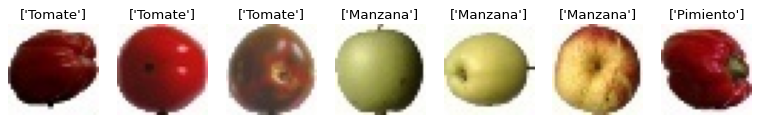

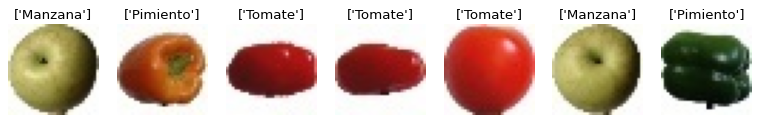

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=80)
for n in range(1, 8):
    fig.add_subplot(4, 7, n)
    img = x_train[n]
    plt.imshow(img)
    plt.title([y_train[n]])
    plt.axis('off')

fig = plt.figure(figsize=(12,8), dpi=80)
for n in range(1, 8):
    fig.add_subplot(4, 7, n)
    img = x_test[n]
    plt.imshow(img)
    plt.title([y_test[n]])
    plt.axis('off')

### Programar una Red Neuronal Convolucional (CNN) por el **MÉTODO FUNCIONAL**

<img width="1000" src="https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/CNN-08.png">
---



## **One-hot encoding**
Con el siguiente código podemos codificar (y descodificar) one-hot encoding:

In [ ]:
from sklearn.preprocessing import OneHotEncoder # Librería scikit-learn (alias sklearn)
ohe = OneHotEncoder(sparse=False)

def codificar_onehot(labels):
  labels_encode = ohe.fit_transform(labels.reshape(-1, 1))
  return labels_encode

def decodificar_onehot(labels):
  labels_decode = ohe.inverse_transform(labels).ravel()
  return labels_decode

y_train_onehot = codificar_onehot(y_train)
y_test_onehot = codificar_onehot(y_test)
print('\nEtiquetas en one-hot encoding de los tres primeros ejemplos:\n', y_train_onehot[0:3])


Etiquetas en one-hot encoding de los tres primeros ejemplos:
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Existen otros optimizadores como SGD y RMSprop

class CNN():

  def build_model():

    inputs = Input((32, 32, 3)) # Función de entrada donde definimos el tamaño del vector o imagen de entrada

    conv = Conv2D(64, 3, activation='relu')(inputs) # Primera capa convolucional
    maxPooling = MaxPooling2D(2)(conv) # Max pooling
    conv = Conv2D(64, 3, activation ='relu')(maxPooling) # Segunda capa convolucional
    maxPooling = MaxPooling2D(2)(conv) # Max pooling
    conv = Conv2D(64,3 )(maxPooling) # Tercera capa convolucional
    conv = Activation('relu')(conv) # Activación de la tercera capa convolucional
    flat = Flatten()(conv) # Capa para convertir los mapas de activación en un vector (una dimensión)

    output = Dense(3, activation='softmax')(flat) # Capa de salida

    model = Model(inputs=inputs , outputs=output) # Se genera el modelo

    # Se compila el modelo donde se dice qué optimizador (con qué tasa de aprendizaje), función de pérdidas y métricas usaremos
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

cnn = CNN.build_model()
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

## **Entrenamiento de la red**

In [ ]:
H = cnn.fit(x_train, y_train_onehot, epochs=10, batch_size=256, verbose=1, validation_split=0.2, shuffle='True')

Epoch 1/10
44/44 [==============================] - 11s 25ms/step - loss: 0.6436 - accuracy: 0.7008 - val_loss: 0.3274 - val_accuracy: 0.8652
Epoch 2/10
44/44 [==============================] - 1s 12ms/step - loss: 0.1952 - accuracy: 0.9298 - val_loss: 0.1095 - val_accuracy: 0.9650
Epoch 3/10
44/44 [==============================] - 1s 12ms/step - loss: 0.0694 - accuracy: 0.9827 - val_loss: 0.0399 - val_accuracy: 0.9936
Epoch 4/10
44/44 [==============================] - 1s 15ms/step - loss: 0.0289 - accuracy: 0.9962 - val_loss: 0.0162 - val_accuracy: 0.9993
Epoch 5/10
44/44 [==============================] - 1s 14ms/step - loss: 0.0122 - accuracy: 0.9987 - val_loss: 0.0086 - val_accuracy: 0.9996
Epoch 6/10
44/44 [==============================] - 1s 13ms/step - loss: 0.0079 - accuracy: 0.9993 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/10
44/44 [==============================] - 1s 16ms/step - loss: 0.0041 - accuracy: 0.9999 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/10
4

# **Evaluación del modelo final con método funcional**


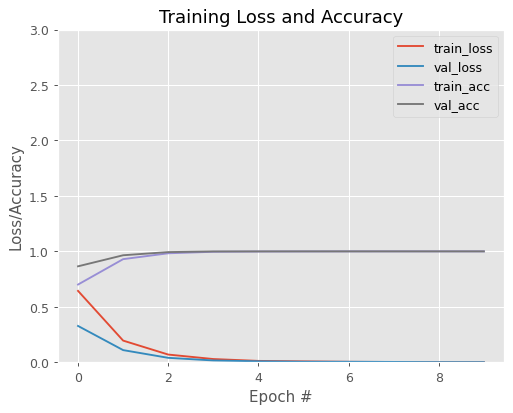

In [ ]:
# Gráficas
plt.style.use("ggplot")
plt.figure(dpi=90)
eje_x = np.arange(0, len(H.history['loss']))
plt.plot(eje_x, H.history["loss"], label="train_loss")
plt.plot(eje_x, H.history["val_loss"], label="val_loss")
plt.plot(eje_x, H.history["accuracy"], label="train_acc")
plt.plot(eje_x, H.history["val_accuracy"], label="val_acc")
plt.ylim(0, 3)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluación del modelo final
print("[INFO]: Evaluando el modelo final...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = cnn.predict(x_test, batch_size=256, verbose=1)
print("[INFO]: Predicción para el ejemplo 0:",predictions[0])
print("[INFO]: Ground truth (salida esperada) para el ejemplo 0:",y_test[0])

# Sacamos la matriz de confusión y el report para el conjunto de datos test
from sklearn.metrics import classification_report, confusion_matrix
print("\n [INFO]: Matriz de confusión (test)")
print(confusion_matrix(y_test_onehot.argmax(axis=1), predictions.argmax(axis=1)))
print("\n[INFO]: Report (test)")
print(classification_report(y_test_onehot.argmax(axis=1), predictions.argmax(axis=1)))

[INFO]: Evaluando el modelo final...
19/19 [==============================] - 0s 8ms/step
[INFO]: Predicción para el ejemplo 0: [1.000000e+00 5.069002e-19 2.334552e-08]
[INFO]: Ground truth (salida esperada) para el ejemplo 0: Manzana

 [INFO]: Matriz de confusión (test)
[[2134    0    0]
 [   1  770   55]
 [   0    0 1707]]

[INFO]: Report (test)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2134
           1       1.00      0.93      0.96       826
           2       0.97      1.00      0.98      1707

    accuracy                           0.99      4667
   macro avg       0.99      0.98      0.98      4667
weighted avg       0.99      0.99      0.99      4667



# **Visualización de resultados del modelo final**


 Vamos a predecir la imagen 150, que tiene como etiqueta real Manzana


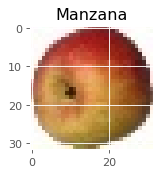



 Vamos a predecir la imagen 4300, que tiene como etiqueta real Tomate


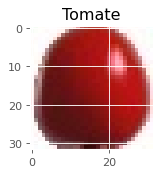

In [ ]:
# Función para visualizar un ejemplo (con su etiqueta)
def visualizar_fruta(datos, etiquetas, num):
  plt.figure(figsize=(2, 2), dpi=80) # Esta línea es para que el plot sea más pequeño
  image = datos[num]
  label = etiquetas[num]
  # Mostrar
  plt.title(label)
  plt.imshow(image)
  plt.show()

# En primer lugar, convertimos las etiquetas predichas en one-hot encoding a las etiquetas originales.
predictions_human_label = decodificar_onehot(predictions)

print('\n', 'Vamos a predecir la imagen 150, que tiene como etiqueta real', y_test[1500])
visualizar_fruta(x_test, predictions_human_label, 1500)

print('\n\n', 'Vamos a predecir la imagen 4300, que tiene como etiqueta real', y_test[4300])
visualizar_fruta(x_test, predictions_human_label, 4300)